In [1]:
import dgl.nn as dglnn
import dgl
import torch_geometric
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('NF-ToN-IoT.csv')

In [3]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [4]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [5]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [6]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [7]:
data = data.sample(frac=.33)

In [8]:
data.drop(columns=['Label'],inplace = True)

In [9]:
data.rename(columns={"Attack": "label"},inplace = True)

In [10]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [11]:
label = data.label

In [12]:
data.drop(columns=['label'],inplace = True)

In [13]:
scaler = StandardScaler()

In [14]:
data =  pd.concat([data, label], axis=1)

In [15]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
774399,172.17.163.65:29351,203.119.86.101:53,17,5.000,77,408,1,1,0,25,0
842902,172.24.174.94:7891,13.107.24.4:53,17,5.212,76,162,1,1,0,123,0
981581,172.21.230.184:55847,192.168.1.1:53,17,5.000,71,71,1,1,0,25,2
265859,172.25.59.71:45624,192.168.1.152:80,6,7.000,698,3812,5,7,27,158,9
96138,172.22.228.245:58938,192.168.1.152:80,6,7.000,507,3700,5,5,27,250,8
...,...,...,...,...,...,...,...,...,...,...,...
750383,172.26.40.232:47906,192.168.1.184:443,6,91.000,1073,2215,8,8,31,193,4
549927,172.24.78.255:55634,192.168.1.184:443,6,91.000,1129,2215,8,8,31,155,4
180773,172.17.163.252:33108,192.168.1.152:80,6,7.000,782,3760,5,6,27,90,4
855630,172.30.67.241:61908,192.168.1.33:8080,6,131.000,1440,1200,30,30,22,10158,1


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.4, random_state=42,stratify= label)

In [ ]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [18]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [19]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [20]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [21]:
G = G.to_directed()


In [22]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [23]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [24]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [25]:
G

Graph(num_nodes=294256, num_edges=546192,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [26]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [27]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [28]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        #if isinstance(g_dgl, th.Tensor):
            #g_dgl = G
            #nfeats=pyg_graph.x
            #efeats= pyg_graph.efeats
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [29]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [30]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [31]:
G.ndata['h']

tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]])

In [32]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 10)
    def forward(self, g_dgl, nfeats, efeats):
        h = self.gnn(g_dgl, nfeats, efeats)
        return self.pred(g_dgl, h)

In [33]:
from sklearn.utils import class_weight
class_weights = [5.1032e+01, 7.9973e+00, 4.2264e+00, 4.7852e+00, 5.9438e+01, 1.0651e+02,
        8.8245e+01, 9.7360e+02, 10.4252e+01, 1.3800e-01]

In [34]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [35]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [36]:
G.ndata['h'].device


device(type='cuda', index=0)

In [37]:
G.edata['h'].device


device(type='cuda', index=0)

In [38]:
G.ndata['h'].shape[2]

8

In [39]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,1000):
    pred = model(G, node_features, edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.4945092499256134
Training acc: 0.6172701120376587
Training acc: 0.6333377361297607
Training acc: 0.6463844180107117
Training acc: 0.6362048387527466
Training acc: 0.6594274640083313
Training acc: 0.6668424010276794
Training acc: 0.6681588292121887
Training acc: 0.6687226891517639


In [40]:
model

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=16, out_features=128, bias=True)
        (W_apply): Linear(in_features=136, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=136, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
X_test = encoder.transform(X_test)

In [42]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [43]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
627048,172.16.33.42:58164,192.168.1.184:443,0.311841,-1.187579,-0.003060,0.066303,-0.004040,0.001362,0.250482,-0.049835,4
1301522,172.29.195.73:34826,192.168.1.184:443,0.311841,-1.187579,-0.007250,-0.035870,-0.006492,-0.012295,-0.377018,-0.054790,2
457603,172.18.47.95:46782,18.184.104.180:80,0.311841,0.753103,-0.005105,0.136036,-0.005266,0.001362,0.895318,-0.041252,4
830460,172.30.144.59:61574,239.255.255.250:3702,-2.919167,-2.309513,0.027906,-0.036679,-0.004653,-0.013536,-1.128754,-0.046957,0
1135811,172.28.254.126:60222,192.168.1.190:80,0.311841,0.753103,-0.007250,-0.035870,-0.006492,-0.012295,-0.377018,-0.054790,2
...,...,...,...,...,...,...,...,...,...,...,...
1220174,172.21.123.14:44516,192.168.1.190:80,0.311841,0.753103,-0.007250,-0.035870,-0.006492,-0.012295,-0.377018,-0.054790,4
795771,172.21.251.246:62139,192.168.1.1:41952,0.311841,0.753103,-0.005619,0.021948,-0.004959,-0.002363,0.895318,-0.054674,0
552410,172.28.55.247:42128,192.168.1.195:80,0.311841,0.753103,-0.005860,-0.007527,-0.005573,-0.007329,0.895318,-0.052094,4
621389,172.18.96.100:36610,192.168.1.190:80,0.311841,0.753103,-0.005494,-0.006503,-0.005573,-0.006087,0.895318,-0.053916,6


In [44]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [45]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
A_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [46]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [47]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [48]:
G_test = G_test.to('cuda:0')


In [49]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [50]:
print(str(elapsed) + ' seconds')


0.2572349000000713 seconds


In [51]:
test_pred = test_pred.argmax(1)


In [52]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [53]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay


In [55]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

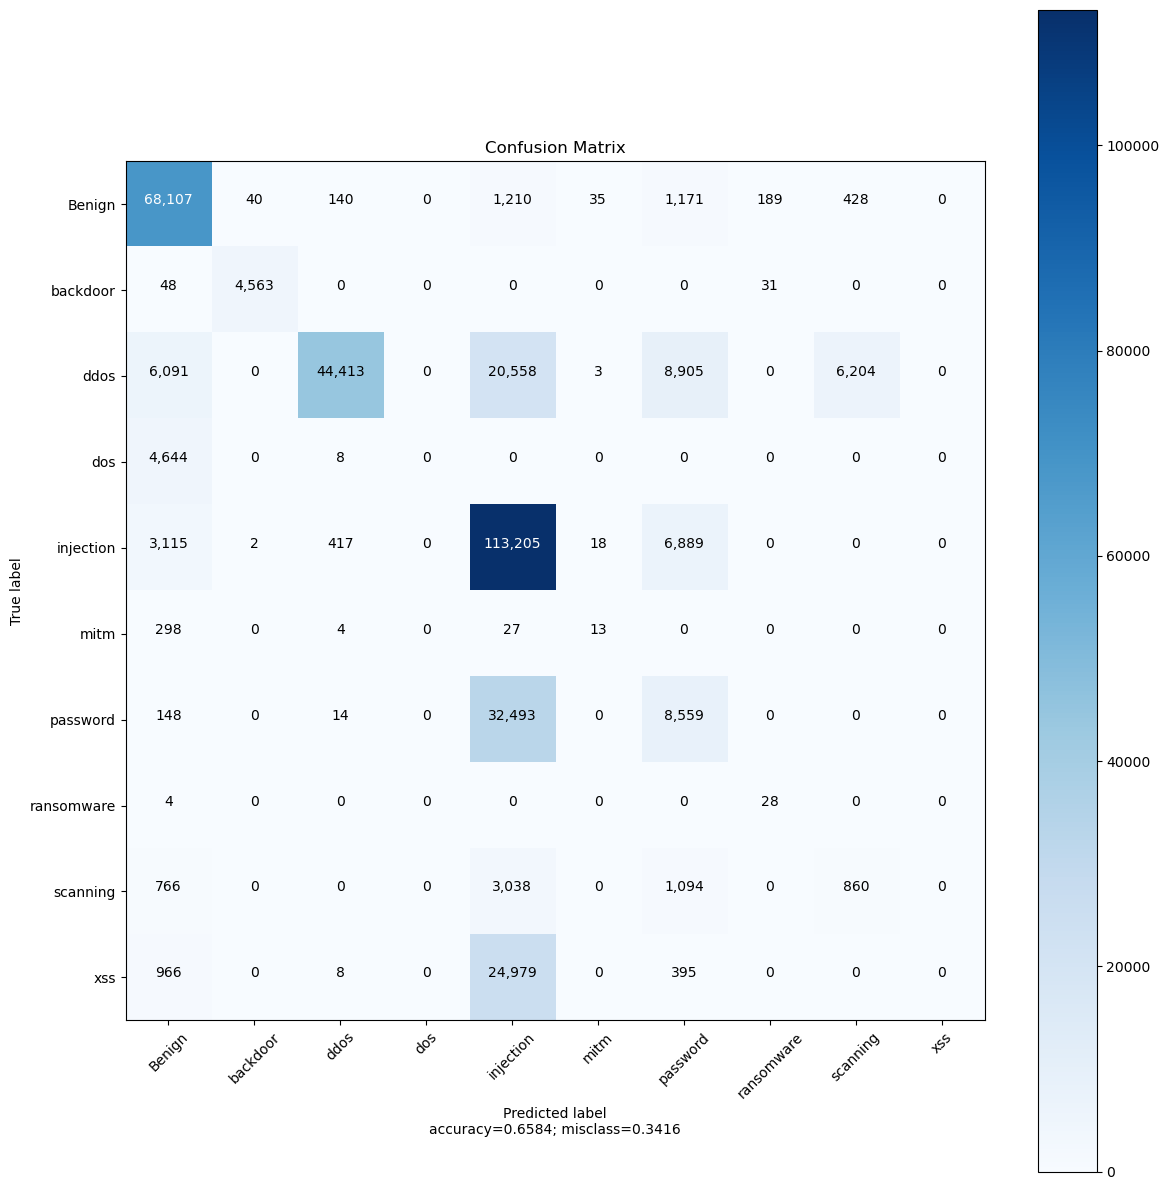

In [56]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [ ]:
import torch_geometric.data as pyg

# Assuming G_test is your DGL graph
edges = G.edges()

# Convert node features from DGL to PyG format
node_features = th.tensor(G.ndata['h'])

# Convert edge features from DGL to PyG format
edge_features = th.tensor(G.edata['h'])

# Get edge indices from DGL graph
# Concatenate source and destination tensors along dim=0
edge_index = th.stack([edges[0], edges[1]], dim=0)

print("Edge index before transpose:")
print(edge_index)

# Transpose the edge index tensor
edge_index = edge_index.long().contiguous()
edge_index = edge_index.view(2, -1)

print("\nEdge index after transpose:")
print(edge_index)

# Create PyG Data object
pyg_graph = pyg.Data(
    x=node_features,  # Node features
    edge_index=edge_index,  # Edge indices
    efeats=edge_features  # Edge features
)

# Print PyG graph information
print(pyg_graph)

In [ ]:
edges[1]

In [ ]:
homoG = dgl.to_homogeneous(G)
netX = dgl.to_networkx(homoG.cpu())

In [ ]:
dataX = torch_geometric.utils.from_networkx(netX)

In [ ]:
G

In [ ]:
model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

In [ ]:
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, CaptumExplainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',
    ),
)

# Generate explanation for the node at index `10`:
explanation = explainer(pyg_graph.x, pyg_graph.edge_index, efeats=pyg_graph.efeats, index=10)
print(explanation.edge_mask)
print(explanation.node_mask)

In [ ]:
pyg_graph.x

In [ ]:
model

In [ ]:
print(model.gnn)

In [ ]:
model.gnn(G_test, nfeats, efeats)

In [ ]:
dataX

In [ ]:
pyg_graph

In [ ]:
G_test.edata['h'].size()

In [ ]:
netX

In [ ]:
G

In [ ]:
g_dgl

In [ ]:
G

In [ ]:
model(G, nfeats=pyg_graph.x, efeats=pyg_graph.efeats)